In [87]:
import numpy as np
from matplotlib import pyplot as plt

In [88]:
# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwith (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20

In [89]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

#####################################################################################################
    
def received_power(transmitted_power, distance):
    return transmitted_power * (k / (distance**n))
    
def bandwith_channel(total_bandwith, channels_quantity):
    return total_bandwith / channels_quantity

def noise_power(total_bandwith, channels_quantity):
    return k_0 * bandwith_channel(total_bandwith, channels_quantity)

##################################################################################################

def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [90]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, power_ = 1): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.distance2AP = np.sqrt((np.random.rand()*1e3 - 500)**2 
                                    + (np.random.rand()*1e3 - 500)**2) 
        
        self.power = power_

In [91]:
# Creates and stores the UES
class UserGenerator:
    
    def __init__(self, quantity_):
        
        self.quantity = quantity_
        
        # list of powers receiveds by AP (watts)
        self.users_power = np.zeros(quantity_)
        
        for i in range(quantity_):
            temp_user = UserEquipment()
            if temp_user.distance2AP >= d0:
                self.users_power[i] = received_power(temp_user.power, 
                                                     temp_user.distance2AP)

In [92]:
# Admiting only 1 channel, the noise power
noise_p = noise_power(b_t, 1)

# Models a System to manage the link between UE and AP
class LinkSystem:
    
    def __init__(self, users_generator_):
        
        if isinstance(users_generator_, UserGenerator):
            
            self.SNR_list = np.zeros(len(users_generator_.users_power))
            self.SINR_list = np.zeros(len(users_generator_.users_power))
            self.capacity_list = np.zeros(len(self.SINR_list))
            
            # Calculating SNR
            for user_ in range(len(users_generator_.users_power)):
                self.SNR_list[user_] = lin2db(users_generator_.users_power[user_]) - lin2db(noise_p)            
    
            # Calculating SINR
            for user__ in range(len(users_generator_.users_power)):
                auxiliar_received_power = list(users_generator_.users_power)
                UE_used = users_generator_.users_power[user__]
                auxiliar_received_power.pop(user__)
                interfering_sum = sum(auxiliar_received_power)
                
                self.SINR_list[user__] = (lin2db(UE_used) 
                                          - lin2db(interfering_sum) 
                                          - lin2db(noise_p))
    
            # Calculating Capacity
            for user_SINR_ in range(len(self.SINR_list)):
                bandwith_ = bandwith_channel(b_t, 10)
                self.capacity_list[user_SINR_] = (bandwith_ * np.log2(1 + db2lin(self.SINR_list[user_SINR_]))) / 1e6

In [93]:
iteracoes = 1000

def simulate(iteracoes):

    total_SNR = []
    total_SINR = []
    total_capacity = []
    
    for inter in range(iteracoes):
        # Creates many Users at once
        users = UserGenerator(20)
        
        # The SNR and SINR of users
        system = LinkSystem(users)
        
        total_SNR = np.concatenate((total_SNR, system.SNR_list))
        
        total_SINR = np.concatenate((total_SINR, system.SINR_list))
        
        total_capacity = np.concatenate((total_capacity, system.capacity_list))

[101.14194571 105.1502537  105.24716763 ... 579.57937171 587.06516182
 587.28084467]


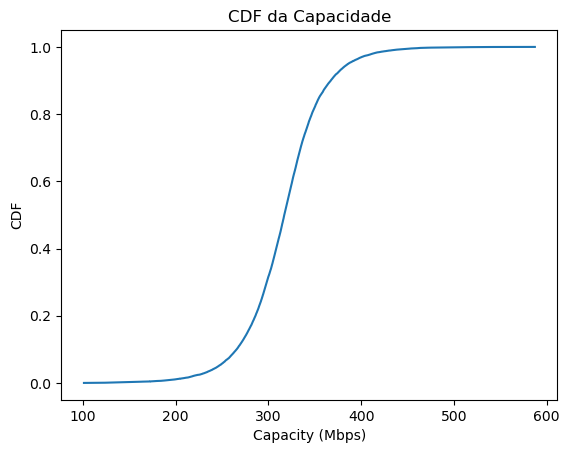

In [94]:
capacityCDF = eCDF(total_capacity)

plt.title('CDF da Capacidade')
plt.xlabel('Capacity (Mbps)')
plt.ylabel('CDF')

plt.plot(capacityCDF[0], capacityCDF[1])
plt.show()